# Toy Experiment for Paper "When Scores Learn Geometry"

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define model
class MLP(nn.Module):
    def __init__(self, x_dim, t_dim, hidden_dim=128, num_layers=3):
        in_dim = x_dim + t_dim
        out_dim = x_dim
        super(MLP, self).__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, xt, t):
        return self.net(torch.cat([xt, t], dim=-1))

Generate data from $x_0^2 + x_1^2 = 1$ manifold. density is linearly increasing from 0 to 1. 


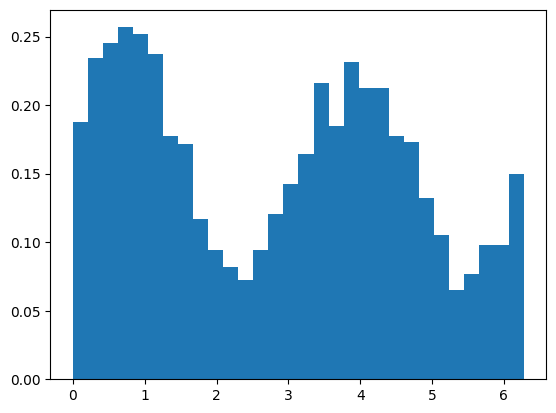

In [2]:
num_train_samples = 4096
batch_size = 512

# sample theta from any distribution
grid = np.linspace(0, 2 * np.pi, int(num_train_samples * 16))
weights = np.sin(2.0 * grid) + 2.0
indices = np.random.choice(grid, num_train_samples, p=weights / weights.sum())
theta = torch.from_numpy(indices).float().to(device)
x = torch.stack([torch.cos(theta), torch.sin(theta)], dim=-1)
# normalize
x1 = (x - x.mean(dim=0)) / x.std(dim=0)

dataset = TensorDataset(x)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# plot theta
theta_np = theta.cpu().numpy()
plt.figure()
plt.hist(theta_np, bins=30, density=True)
plt.show()

train velocity field

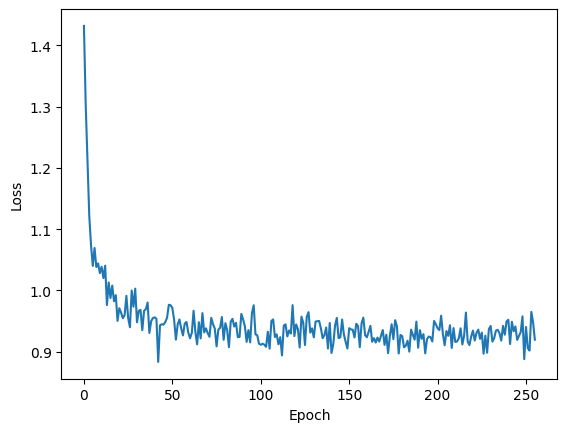

In [3]:
num_epochs = 256
model = MLP(x_dim=2, t_dim=1, hidden_dim=1024, num_layers=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_history = []
for epoch in range(num_epochs):
    epoch_loss_sum = 0.0
    for x1, in dataloader:  # Unpack Tuple for x1
        bs = x1.shape[0]
        t = torch.rand((bs, 1), device=device)
        x0 = torch.randn((bs, 2), device=device)
        xt = t * x1 + (1 - t) * x0
        vel_target = (x1 - x0) / 1.0
        vel_pred = model(xt, t)
        loss = F.mse_loss(vel_pred, vel_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss_sum += loss.item()
    epoch_loss = epoch_loss_sum / len(dataloader)
    loss_history.append(epoch_loss)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

inference with velocity field

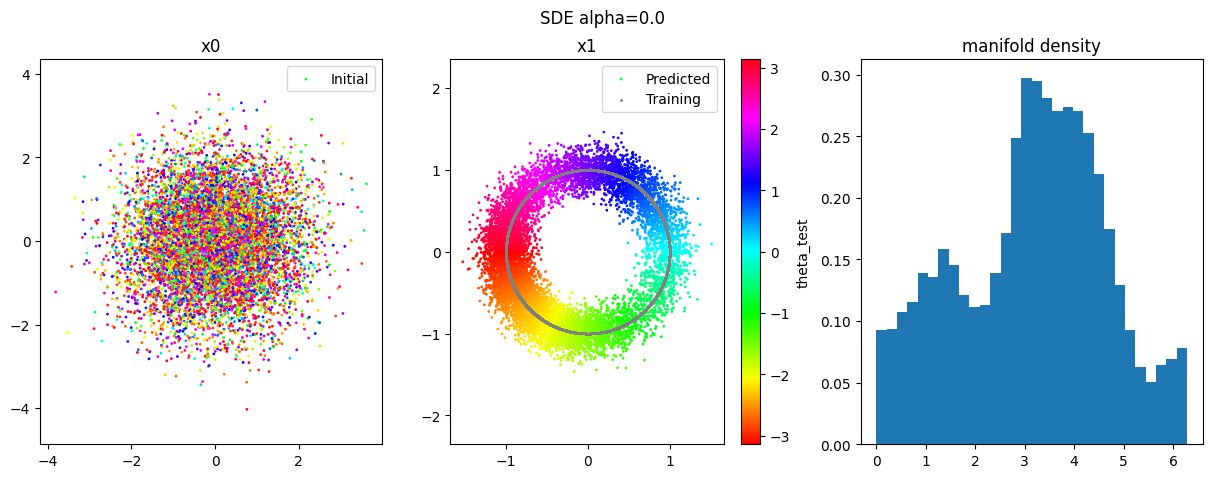

In [36]:
alpha = 0.0
num_test_samples = 10000
num_integration_steps = 500
x0 = torch.randn((num_test_samples, 2), device=device)
ts = np.linspace(0, 1, num_integration_steps+1)

xt = x0
for i in range(num_integration_steps):
    s = ts[i]
    t = ts[i+1]
    s_tensor = torch.full((num_test_samples, 1), s, device=device)
    with torch.no_grad():
        vel_pred = model(xt, s_tensor)
    # ode integrator
    # xt = xt + vel_pred * (t - s) #* ((1 - s) ** 2)
    # sde integrator
    # xs = xt
    # dt = t - s
    # score_w = (s * vel_pred  - xs)
    # w = 1 - s
    # dw = np.sqrt(dt) * torch.randn_like(xt, device=device)
    # xt = xs + vel_pred * dt + 0.5 * score_w * dt + np.sqrt(w) * dw
    # langevin integrator
    sigma = 0.1
    s = 1 - sigma
    score = (s * vel_pred  - xt) / (1 - s)
    dt = 0.01
    dw = np.sqrt(dt) * torch.randn_like(xt, device=device)
    xt = xt + (sigma ** alpha) * score * dt + np.sqrt(2) * dw

    
x0_test = x0.cpu().numpy()
x1_test = xt.cpu().numpy()
x1_train = x.cpu().numpy()

theta_test = np.arctan2(x1_test[:, 1], x1_test[:, 0])
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sc0 = axs[0].scatter(x0_test[:, 0], x0_test[:, 1], c=theta_test, cmap="hsv", s=1, label="Initial")
sc1 = axs[1].scatter(x1_test[:, 0], x1_test[:, 1], c=theta_test, cmap="hsv", s=1, label="Predicted")
# fig.suptitle("ODE integrator")
fig.suptitle(f"SDE alpha={alpha:.1f}")
axs[1].scatter(x1_train[:, 0], x1_train[:, 1], s=1, color='gray', label="Training")
axs[0].legend()
axs[1].legend()
axs[0].axis("equal")
axs[1].axis("equal")
# plot theta histogram for test data
axs[2].hist(theta_test % (2 * np.pi), bins=30, density=True)
axs[0].set_title("x0")
axs[1].set_title("x1")
axs[2].set_title("manifold density")
plt.colorbar(sc1, ax=axs[1], label="theta_test")
plt.show()